# Libraries

In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt, log
from scipy.linalg import expm
import itertools
import time
import sys
sys.path.append('./../content/equadratures')
sys.path.append('./../src/Diff.py')
import equadratures as eq

In [2]:
from scipy.integrate import solve_ivp
from IPython.display import clear_output
import os



In [5]:
from Diff import *

ModuleNotFoundError: No module named 'Diff'

In [6]:
import matplotlib.lines as mlines
import cvxpy as cp

# MOSEK installation

In [6]:
from cvxpy.reductions.solvers import defines as slv_def
slv_def.INSTALLED_SOLVERS.append('MOSEK')


# Graph initialization

In [7]:
twitter = nx.read_weighted_edgelist('../data/congress_network/congress.edgelist', )

In [8]:
# pos = nx.spring_layout(twitter, iterations=15, seed=1721)
# fig, ax = plt.subplots(figsize=(15, 9))
# ax.axis("off")
# plot_options = {"node_size": 10, "with_labels": False, "width": 0.15, "alpha":0.2}
# nx.draw_networkx(twitter, pos=pos, ax=ax, **plot_options)
coms = nx.community.asyn_fluidc(twitter, 2, seed=0)

In [8]:
def graph_perm_matrix(coms): 
    final_index = []
    coms_new = []
    for com in coms:
        coms_new.append(list(com))
        final_index+= [int(i) for i in com]
    initial_index = [i for i in range(len(final_index))]
    P = np.zeros((len(final_index), len(final_index)), dtype=int)

    P[final_index, initial_index] = 1
    return P, coms_new

In [11]:
def initialize_graph(G, num_coms=2, activ_ratio = 0.2):

  A = nx.adjacency_matrix(G).todense()
  L = nx.laplacian_matrix(G).toarray()

  n = G.number_of_nodes()
  x0 = np.ones(n)
  coms = nx.community.asyn_fluidc(G, num_coms, seed=0)
  P, coms = graph_perm_matrix(coms)
  A = P @ A @ P.T
  L = P @ L @ P.T
  activ = np.random.choice(n, int(activ_ratio*n))
  x0[activ] = 100
  sizes = []
  coms_list = []
  for com in coms:
    sizes.append(len(list(com)))
    coms_list.append(com)

  return G, n, A, L, coms_list, sizes, x0


In [9]:
from random import randint
partition = dict()
for id, com in enumerate(nx.community.asyn_fluidc(twitter, 2, seed=0)):
    color = "#%06X" % randint(0, 0xFFFFFF)  # creates random RGB color
    for node in list(com):
        partition[node] = id
# plt.figure(figsize=(15, 9))
# plt.axis("off")
# nx.draw_networkx(
#     twitter, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=colors
# )

In [10]:
#check if it is a partition
partition.items()
class0 = []
class1 = []
for item in partition.items():
    if item[1] == 0:
        class0.append(int(item[0]))
    elif item[1] == 1:
        class1.append(int(item[0]))


In [98]:
sorted(class0)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 168,
 181,
 213,
 230,
 243,
 280,
 282,
 284,
 342,
 361,
 366,
 411,
 425,
 437,
 444,
 448,
 459,
 463]

In [11]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities, hypergraph = _position_communities(g, partition, scale=2.)
    pos_nodes = _position_nodes(g, partition, scale=2)

    # combine positions
    pos = dict()
    class0 = []
    class1 = []
    for node in g.nodes():
        pos[node] = pos_communities[node]+ pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos, hypergraph

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [12]:
def drop_weights(G):
    '''Drop the weights from a networkx weighted graph.'''
    for node, edges in nx.to_dict_of_dicts(G).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)
drop_weights(twitter)
pos= community_layout(twitter, partition)

In [15]:
color1 = "#%06X" % randint(0, 0xFFFFFF)
color2 ="#%06X" % randint(0, 0xFFFFFF)
colors_int = dict()
for node, com in pos.items():
    if com[1]>0:
        colors_int[int(node)] = color1
    else:
        colors_int[int(node)] = color2

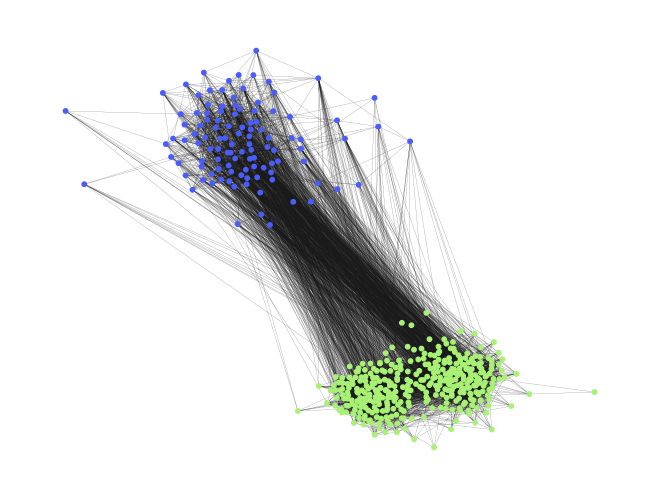

In [16]:
nx.draw(twitter, pos, node_size=10, with_labels=False, width=0.1, node_color=list(colors_int.values()))

# Custom functions

In [23]:
#no-time&edge dependent
def ed_diff_function(y):
  y = (y+1)/2
  c_bar = construct_cbar(y)
  print(sizes)
  C = construct_C(c_bar, sizes, n)
  D = construct_D(A, C, n)
  M = C*A - D

  diff_2 = ed_diffusion(M, x0, tau=0.01, T=1)

  return diff_2[2,-1]

In [14]:
#time&edge dependent diff equation
def ted_diff_function(y):
  c_bar = construct_cbar(y)

  C = construct_C(c_bar, sizes, n)
  M_t = construct_Mt(A, C, sizes, alpha=[2,3,4])

  diff = backward_euler_NC(x0, 0.01, M_t)

  return diff[2,-1]

In [15]:
# Custom solvers

solver = cp.MOSEK

def qcbp(A, b, eta=1e-6, **kwargs):
  n = A.shape[1]
  z = cp.Variable(n)
  b = np.reshape(b, (b.shape[0],))  # to avoid shape issues when defining the constraint
  objective = cp.Minimize(cp.norm1(z))
  constraints = [cp.norm2(A@z-b) <= eta]
  prob = cp.Problem(objective, constraints)
  result = prob.solve(solver=solver)

  return z.value #.reshape((n,1))


def ls(A, b, **kwargs):
  n = A.shape[1]
  z = cp.Variable(n)
  b = np.reshape(b, (b.shape[0],))  # to avoid shape issues when defining the constraint
  objective = cp.Minimize(cp.norm2(A@z-b))
  prob = cp.Problem(objective)
  result = prob.solve(solver=solver)

  return z.value #.reshape((n,1))

In [16]:
def get_average_rmse(m, my_method, dim=3, simuls=5, basis='total-order', ord=4):
  errors = np.array([])
  my_param_list = [eq.Parameter(distribution='uniform', order=ord, lower=-1.0, upper=1.0) for i in range(dim)]

  #if basis == 'hyperbolic-cross':
  my_basis = eq.Basis(basis, orders=[ord for _ in range(dim)])
  #else:
  #  my_basis = eq.Basis(basis)


  if my_method == qcbp:
    poly = eq.Poly([eq.Parameter(distribution='uniform', order=ord, lower=-1.0, upper=1.0) for _ in range(dim)], my_basis)
    index_set_size = my_basis.get_cardinality()
    M = 10 * index_set_size
    err_grid = np.random.uniform(-1, 1, size=(M, dim))
    A_err_grid = poly.get_poly(err_grid).T/sqrt(M)
    b_err_grid = eq.evaluate_model(err_grid, ed_diff_function)/sqrt(M)
    c_ref, _, _, _ = np.linalg.lstsq(A_err_grid, b_err_grid)

  for j in range(simuls):

    X_train = np.random.uniform(-1, 1, size=(m, dim))
    y_train = eq.evaluate_model(X_train, ed_diff_function)

    if my_method == qcbp:
      my_poly_ref = eq.Poly(my_param_list, my_basis, method='custom-solver',
            sampling_args={'mesh':'user-defined', 'sample-points':X_train, 'sample-outputs':y_train})
      A = my_poly_ref.get_poly(X_train).T
      eta_opt = np.linalg.norm(A@c_ref - y_train)
      my_poly = eq.Poly(my_param_list, my_basis, method='custom-solver',
          sampling_args={'mesh':'user-defined', 'sample-points':X_train, 'sample-outputs':y_train},
            solver_args={'solve':my_method, 'eta':eta_opt, 'verbose':False})
    elif my_method == ls:
      my_poly = eq.Poly(my_param_list, my_basis, method='custom-solver',
          sampling_args={'mesh':'user-defined', 'sample-points':X_train, 'sample-outputs':y_train},
            solver_args={'solve':my_method, 'verbose':False})

    my_poly.set_model()

    test_pts = np.random.uniform(-1, 1, size=(1000, dim))
    test_evals = eq.evaluate_model(test_pts, ed_diff_function)
    train_r2, test_r2 = my_poly.get_polyscore(X_test=test_pts, y_test=test_evals, metric='rmse')
    train_r2, test_r2

    errors = np.append(errors, test_r2)

  return np.mean(errors)

In [17]:
def get_average_rmse_varcoefs(m, my_method, dim=3, simuls=5, basis='total-order', ord=4):
  errors = np.array([])
  my_param_list = [eq.Parameter(distribution='uniform', order=ord, lower=-1.0, upper=1.0) for i in range(dim)]

  for j in range(simuls):
    if basis == 'hyperbolic-cross':
      my_basis = eq.Basis(basis, orders=[ord for _ in range(dim)])
    else:
      my_basis = eq.Basis(basis)
    X_train = np.random.uniform(-1, 1, size=(m, dim))
    y_train = eq.evaluate_model(X_train, ted_diff_function)
    my_poly = eq.Poly(parameters=my_param_list, basis=my_basis, method=my_method, \
                      sampling_args={'mesh':'user-defined', 'sample-points':X_train, \
                                    'sample-outputs':y_train})
    my_poly.set_model()

    test_pts = np.random.uniform(-1, 1, size=(500, dim))
    test_evals = eq.evaluate_model(test_pts, ted_diff_function)
    train_r2, test_r2 = my_poly.get_polyscore(X_test=test_pts, y_test=test_evals, metric='rmse')
    train_r2, test_r2

    errors = np.append(errors, test_r2)

  return np.mean(errors)

In [18]:
def conv(x, method, dim=3, simuls=5, basis='total-order', ord=4, verbose=False):
  Y = []

  for element in x:
    if verbose:
      start = time.time()
    Y.append(get_average_rmse(element, method, dim=dim, simuls=simuls, ord=ord, basis=basis))
    if verbose:
      end = time.time()
      print('m={} w/ {}, done: {} seconds.'.format(element, method, end-start))

  return Y

In [19]:
def conv_varcoefs(x, method, dim=3, simuls=5, basis='total-order', ord=4, verbose=False):
  Y = []

  for element in x:
    if verbose:
      start = time.time()
    Y.append(get_average_rmse_varcoefs(element, method, dim=dim, simuls=simuls, ord=ord, basis=basis))
    if verbose:
      end = time.time()
      print('m={} w/ {}, done: {} seconds.'.format(element, method, end-start))

  return Y

# Polynomial approximation

## Average RMSE vs. number of samples

### d = 3

In [20]:
eq.basis.Basis('total-order', orders=[8 for _ in range(3)]).get_cardinality()

165

In [21]:
eq.basis.Basis('hyperbolic-cross', orders=[30 for _ in range(3)]).get_cardinality()

279

In [55]:
### Convergence plot of average RMSE vs. nb of samples, w/ TD index set

d = 6  # dimension
K = 3  # communities # K=2 -> d = 3

basis = 'total-order'
name_basis = 'total-degree'
order = 8 #4
cardinality = eq.basis.Basis(basis, orders=[order for _ in range(d)]).get_cardinality()  # (7 4, 4) = 35
nb_samples = [10*i for i in range(5, 51)] #[30, 40] 

y_ls = conv(nb_samples, ls, dim=d, simuls=1, basis=basis, ord=order)
y_cs = conv(nb_samples, qcbp, dim=d, simuls=1, basis=basis, ord=order)

3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 202]
3
[96, 177, 20

KeyboardInterrupt: 

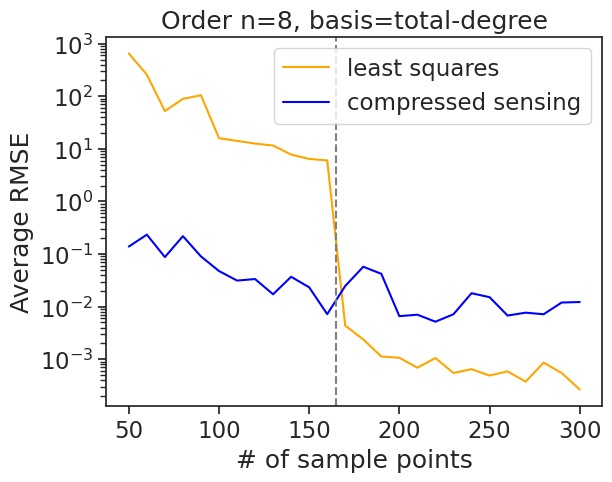

In [ ]:
cutoff = 26

plt.plot(nb_samples[:cutoff], y_ls[:cutoff], 'orange', label='least squares')
plt.plot(nb_samples[:cutoff], y_cs[:cutoff], 'blue', label='compressed sensing')
plt.axvline(x=cardinality, color='grey', linestyle='--')
plt.yscale('log')
plt.xlabel('# of sample points')
plt.ylabel('Average RMSE')
plt.title('Order n={}, basis={}'.format(str(order), name_basis))
plt.legend()
plt.show()

In [ ]:
### Convergence plot of average RMSE vs. nb of samples, w/ HC index set

d = 3  # dimension
K = 2  # communities

G, n, A, L, sizes, x0 = initialize_graph(K, 5)
basis = 'hyperbolic-cross'
name_basis = 'hyperbolic-cross'
order = 20
cardinality = eq.basis.Basis(basis, orders=[order for _ in range(d)]).get_cardinality()  # 161
nb_samples = [10*i for i in range(5, 51)]

y_ls = conv(nb_samples, ls, dim=d, simuls=3, basis=basis, ord=order)
y_cs = conv(nb_samples, qcbp, dim=d, simuls=3, basis=basis, ord=order)

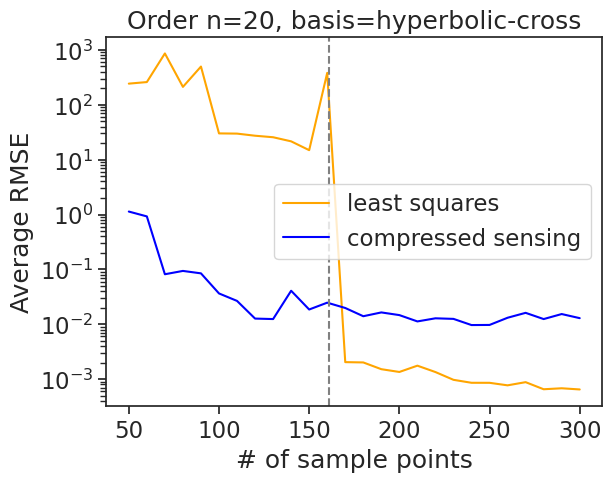

In [ ]:
cutoff = 26

plt.plot(nb_samples[:cutoff], y_ls[:cutoff], 'orange', label='least squares')
plt.plot(nb_samples[:cutoff], y_cs[:cutoff], 'blue', label='compressed sensing')
plt.axvline(x=cardinality, color='grey', linestyle='--')
plt.yscale('log')
plt.xlabel('# of sample points')
plt.ylabel('Average RMSE')
plt.title('Order n={}, basis={}'.format(str(order), name_basis))
plt.legend()
plt.show()

In [ ]:
### Convergence plot of average RMSE vs. nb of samples, w/ HC index set

d = 3  # dimension
K = 2  # communities

G, n, A, L, sizes, x0 = initialize_graph(K, 5)
basis = 'hyperbolic-cross'
name_basis = 'hyperbolic-cross'
order = 30
cardinality = eq.basis.Basis(basis, orders=[order for _ in range(d)]).get_cardinality()  # 279
nb_samples = [10*i for i in range(5, 51)]

y_ls = conv(nb_samples, ls, dim=d, simuls=1, basis=basis, ord=order)
y_cs = conv(nb_samples, qcbp, dim=d, simuls=1, basis=basis, ord=order)

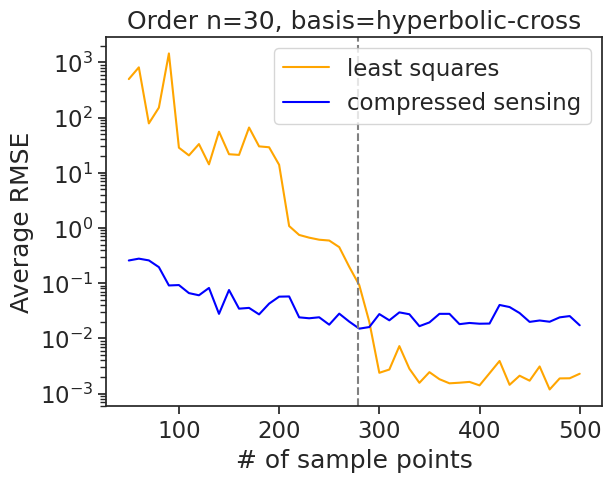

In [ ]:
cutoff = 46

plt.plot(nb_samples[:cutoff], y_ls[:cutoff], 'orange', label='least squares')
plt.plot(nb_samples[:cutoff], y_cs[:cutoff], 'blue', label='compressed sensing')
plt.axvline(x=cardinality, color='grey', linestyle='--')
plt.yscale('log')
plt.xlabel('# of sample points')
plt.ylabel('Average RMSE')
plt.title('Order n={}, basis={}'.format(str(order), name_basis))
plt.legend()
plt.show()

### d = 6

In [ ]:
eq.basis.Basis('total-order', orders=[5 for _ in range(6)]).get_cardinality()

462

In [ ]:
eq.basis.Basis('hyperbolic-cross', orders=[16 for _ in range(6)]).get_cardinality()

537

In [ ]:
### Convergence plot of average RMSE vs. nb of samples, w/ TD index set

d = 6  # dimension
K = 3  # communities

G, n, A, L, sizes, x0 = initialize_graph(K, 5)
basis = 'total-order'
name_basis = 'total-degree'
order = 5
cardinality = eq.basis.Basis(basis, orders=[order for _ in range(d)]).get_cardinality()  # 462
nb_samples = [10*i for i in range(5, 71)]

y_ls = conv(nb_samples, ls, dim=d, simuls=1, basis=basis, ord=order)
y_cs = conv(nb_samples, qcbp, dim=d, simuls=1, basis=basis, ord=order)
clear_output()

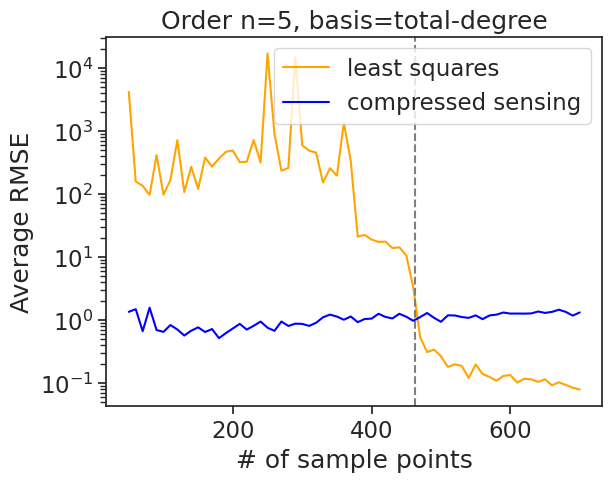

In [ ]:
cutoff = 66

plt.plot(nb_samples[:cutoff], y_ls[:cutoff], 'orange', label='least squares')
plt.plot(nb_samples[:cutoff], y_cs[:cutoff], 'blue', label='compressed sensing')
plt.axvline(x=cardinality, color='grey', linestyle='--')
plt.yscale('log')
plt.xlabel('# of sample points')
plt.ylabel('Average RMSE')
plt.title('Order n={}, basis={}'.format(str(order), name_basis))
plt.legend()
plt.show()

In [ ]:
### Convergence plot of average RMSE vs. nb of samples, w/ HC index set

d = 6  # dimension
K = 3  # communities

G, n, A, L, sizes, x0 = initialize_graph(K, 5)
basis = 'hyperbolic-cross'
name_basis = 'hyperbolic-cross'
order = 12
cardinality = eq.basis.Basis(basis, orders=[order for _ in range(d)]).get_cardinality()  # 333
nb_samples = [10*i for i in range(5, 71)]

y_ls = conv(nb_samples, ls, dim=d, simuls=1, basis=basis, ord=order)
y_cs = conv(nb_samples, qcbp, dim=d, simuls=1, basis=basis, ord=order)

KeyboardInterrupt: 

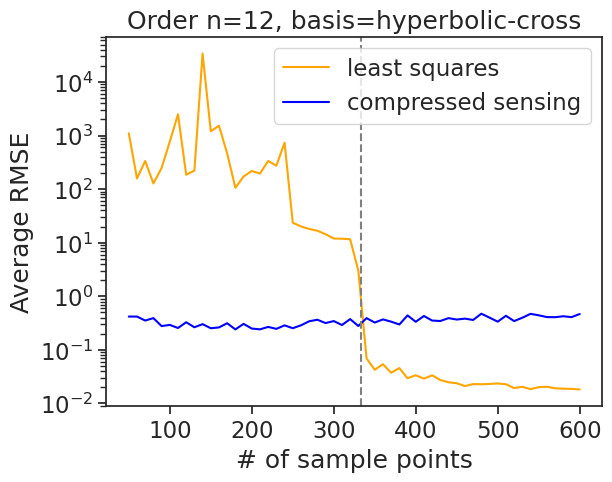

In [ ]:
cutoff = 56

plt.plot(nb_samples[:cutoff], y_ls[:cutoff], 'orange', label='least squares')
plt.plot(nb_samples[:cutoff], y_cs[:cutoff], 'blue', label='compressed sensing')
plt.axvline(x=cardinality, color='grey', linestyle='--')
plt.yscale('log')
plt.xlabel('# of sample points')
plt.ylabel('Average RMSE')
plt.title('Order n={}, basis={}'.format(str(order), name_basis))
plt.legend()
plt.show()

In [ ]:
### Convergence plot of average RMSE vs. nb of samples, w/ HC index set

d = 6  # dimension
K = 3  # communities

G, n, A, L, sizes, x0 = initialize_graph(K, 5)
basis = 'hyperbolic-cross'
name_basis = 'hyperbolic-cross'
order = 16
cardinality = eq.basis.Basis(basis, orders=[order for _ in range(d)]).get_cardinality()  # 537
nb_samples = [10*i for i in range(5, 91)]

y_ls = conv(nb_samples, ls, dim=d, simuls=1, basis=basis, ord=order)
y_cs = conv(nb_samples, qcbp, dim=d, simuls=1, basis=basis, ord=order)

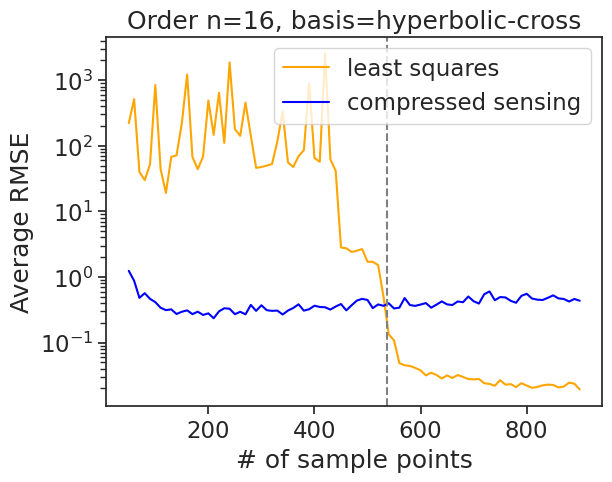

In [ ]:
cutoff = 86

plt.plot(nb_samples[:cutoff], y_ls[:cutoff], 'orange', label='least squares')
plt.plot(nb_samples[:cutoff], y_cs[:cutoff], 'blue', label='compressed sensing')
plt.axvline(x=cardinality, color='grey', linestyle='--')
plt.yscale('log')
plt.xlabel('# of sample points')
plt.ylabel('Average RMSE')
plt.title('Order n={}, basis={}'.format(str(order), name_basis))
plt.legend()
plt.show()

### d = 10

## Average RMSE vs. cardinality of basis

In [ ]:
print([eq.basis.Basis('hyperbolic-cross', orders=[i for _ in range(3)]).get_cardinality() for i in range(4,52,4)])

[16, 44, 77, 113, 161, 209, 249, 309, 366, 417, 483, 546]


In [ ]:
print([eq.basis.Basis('total-order', orders=[i for _ in range(3)]).get_cardinality() for i in range(3,15)])

[20, 35, 56, 84, 120, 165, 220, 286, 364, 455, 560, 680]


In [ ]:
### Exp 1

d = 3  # dimension
K = 2  # communities

G, n, A, L, sizes, x0 = initialize_graph(K, 5)
m = 350
y_1 = []
y_2 = []
y_3 = []
y_4 = []
TD_orders = [i for i in range(3,15)]
HC_orders = [i for i in range(4,52,4)]

for o1 in TD_orders:
  y_1.append(get_average_rmse(m, ls, dim=d, simuls=1, basis='total-order', ord=o1))
  y_2.append(get_average_rmse(m, qcbp, dim=d, simuls=1, basis='total-order', ord=o1))

for o2 in HC_orders:
  y_3.append(get_average_rmse(m, ls, dim=d, simuls=1, basis='hyperbolic-cross', ord=o2))
  y_4.append(get_average_rmse(m, qcbp, dim=d, simuls=1, basis='hyperbolic-cross', ord=o2))

Y_TD = [y_1, y_2]
card_TD = [eq.basis.Basis('total-order', orders=[i for _ in range(d)]).get_cardinality() for i in TD_orders]

Y_HC = [y_3, y_4]
card_HC = [eq.basis.Basis('hyperbolic-cross', orders=[i for _ in range(d)]).get_cardinality() for i in HC_orders]

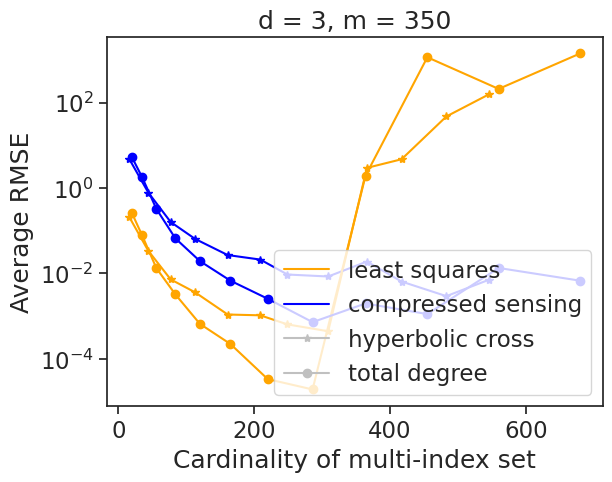

In [ ]:
plt.plot(card_HC, Y_HC[0], color='orange', marker='*')
plt.plot(card_HC, Y_HC[1], color='blue', marker='*')
plt.plot(card_TD, Y_TD[0], color='orange', marker='o')
plt.plot(card_TD, Y_TD[1], color='blue', marker='o')

plt.title('d = {}, m = {}'.format(str(d), str(m)))
plt.xlabel('Cardinality of multi-index set')
plt.ylabel('Average RMSE')
plt.yscale('log')
legend_handles = [mlines.Line2D([], [], color='orange', linestyle='-', label='least squares'),
                  mlines.Line2D([], [], color='blue', linestyle='-', label='compressed sensing'),
                  mlines.Line2D([], [], color='silver', linestyle='-', marker='*', label='hyperbolic cross'),
                  mlines.Line2D([], [], color='silver', linestyle='-', marker='o', label='total degree')]
plt.legend(handles=legend_handles, loc='lower right')
plt.show()

In [ ]:
### Exp 2

d = 3  # dimension
K = 2  # communities

G, n, A, L, sizes, x0 = initialize_graph(K, 5)
m = 1000
y_1 = []
y_2 = []
y_3 = []
y_4 = []
TD_orders = [i for i in range(3,15)]
HC_orders = [i for i in range(4,52,4)]

for o1 in TD_orders:
  y_1.append(get_average_rmse(m, ls, dim=d, simuls=1, basis='total-order', ord=o1))
  y_2.append(get_average_rmse(m, qcbp, dim=d, simuls=1, basis='total-order', ord=o1))

for o2 in HC_orders:
  y_3.append(get_average_rmse(m, ls, dim=d, simuls=1, basis='hyperbolic-cross', ord=o2))
  y_4.append(get_average_rmse(m, qcbp, dim=d, simuls=1, basis='hyperbolic-cross', ord=o2))

clear_output()

Y_TD = [y_1, y_2]
card_TD = [eq.basis.Basis('total-order', orders=[i for _ in range(d)]).get_cardinality() for i in TD_orders]

Y_HC = [y_3, y_4]
card_HC = [eq.basis.Basis('hyperbolic-cross', orders=[i for _ in range(d)]).get_cardinality() for i in HC_orders]

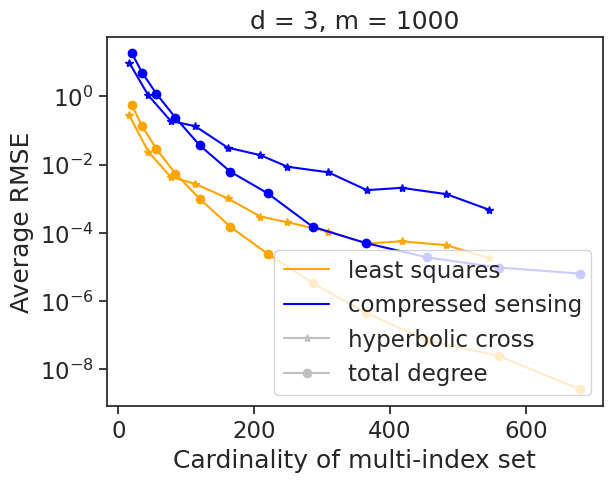

In [ ]:
plt.plot(card_HC, Y_HC[0], color='orange', marker='*')
plt.plot(card_HC, Y_HC[1], color='blue', marker='*')
plt.plot(card_TD, Y_TD[0], color='orange', marker='o')
plt.plot(card_TD, Y_TD[1], color='blue', marker='o')

plt.title('d = {}, m = {}'.format(str(d), str(m)))
plt.xlabel('Cardinality of multi-index set')
plt.ylabel('Average RMSE')
plt.yscale('log')
legend_handles = [mlines.Line2D([], [], color='orange', linestyle='-', label='least squares'),
                  mlines.Line2D([], [], color='blue', linestyle='-', label='compressed sensing'),
                  mlines.Line2D([], [], color='silver', linestyle='-', marker='*', label='hyperbolic cross'),
                  mlines.Line2D([], [], color='silver', linestyle='-', marker='o', label='total degree')]
plt.legend(handles=legend_handles, loc='lower right')
plt.show()

# Old section 1

In [ ]:
d = 3

In [ ]:
nb_samples = [i*50 for i in range(1,41)]

In [ ]:
get_average_rmse_varcoefs(500, 'least-squares', simuls=1, basis='total-order', ord=7)

0.2296661923027443

In [ ]:
methods = ['least-squares', 'compressed-sensing']
orders = [18]
bases = ['hyperbolic-basis']

In [ ]:
for bas in bases:
  for o in orders:
    for met in methods:
      y = conv_varcoefs(nb_samples, met, dim=d, simuls=5, basis=bas, ord=o)
      np.savetxt('Gt2d{}-{}-{}-n{}.txt'.format(d, met, bas, o), np.array([nb_samples, y]), fmt='%1.10e')

In [ ]:
eq.basis.Basis('hyperbolic-basis', orders=[18 for i in range(3)], q=0.5).get_cardinality()

197

# Old section 2

In [ ]:
d

6

In [ ]:
eq.basis.Basis('hyperbolic-cross', orders=[i for _ in range(4)]).get_cardinality()

In [ ]:
#print([eq.basis.Basis('hyperbolic-cross', orders=[i for _ in range(d)]).get_cardinality() for i in range(4,52,4)])
print([eq.basis.Basis('hyperbolic-cross', orders=[i for _ in range(d)]).get_cardinality() for i in range(3,59,7)])

[34, 201, 663, 1230, 1928, 2555, 3407, 4484]


In [ ]:
#print([eq.basis.Basis('total-order', orders=[i for _ in range(d)]).get_cardinality() for i in range(3,15)])
print([eq.basis.Basis('total-order', orders=[i for _ in range(d)]).get_cardinality() for i in range(2,10)])

[28, 84, 210, 462, 924, 1716, 3003, 5005]


In [ ]:
m = 1000

y_1 = []
y_2 = []
for order in range(3,59,7):
  y_1.append(get_average_rmse(m, 'least-squares', dim=d, simuls=1, basis='hyperbolic-cross', ord=order))
  y_2.append(get_average_rmse(m, 'compressed-sensing', dim=d, simuls=1, basis='hyperbolic-cross', ord=order))

Y_HC = [y_1, y_2]
card_HC = [eq.basis.Basis('hyperbolic-cross', orders=[i for _ in range(d)]).get_cardinality() for i in range(3,59,7)]

y_3 = []
y_4 = []
for order in range(2,10):
  y_3.append(get_average_rmse(m, 'least-squares', dim=d, simuls=1, basis='total-order', ord=order))
  y_4.append(get_average_rmse(m, 'compressed-sensing', dim=d, simuls=1, basis='total-order', ord=order))

Y_TD = [y_3, y_4]
card_TD = [eq.basis.Basis('total-order', orders=[i for _ in range(d)]).get_cardinality() for i in range(2,10)]

KeyboardInterrupt: 

In [ ]:
card_HC = [eq.basis.Basis('hyperbolic-cross', orders=[i for _ in range(d)]).get_cardinality() for i in range(3,59,7)]
card_TD = [eq.basis.Basis('total-order', orders=[i for _ in range(d)]).get_cardinality() for i in range(2,10)]

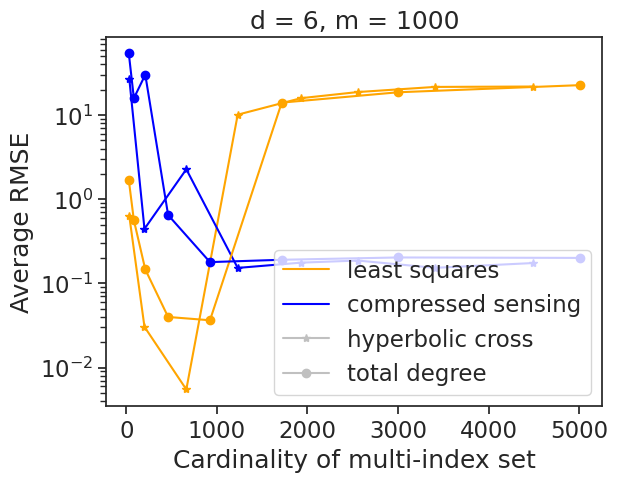

In [ ]:
plt.plot(card_HC, Y_HC[0], color='orange', marker='*')
plt.plot(card_HC, Y_HC[1], color='blue', marker='*')
plt.plot(card_TD, Y_TD[0], color='orange', marker='o')
plt.plot(card_TD, Y_TD[1], color='blue', marker='o')

plt.title('d = {}, m = {}'.format(str(d), str(m)))
plt.xlabel('Cardinality of multi-index set')
plt.ylabel('Average RMSE')
plt.yscale('log')
legend_handles = [mlines.Line2D([], [], color='orange', linestyle='-', label='least squares'),
                  mlines.Line2D([], [], color='blue', linestyle='-', label='compressed sensing'),
                  mlines.Line2D([], [], color='silver', linestyle='-', marker='*', label='hyperbolic cross'),
                  mlines.Line2D([], [], color='silver', linestyle='-', marker='o', label='total degree')]
plt.legend(handles=legend_handles, loc='lower right')
plt.show()